# Trained regressors in optimization models

#### Robert Luce (Gurobi Optimization)

## Mixed-integer optimization

\begin{alignat}{3}
\min_{x,y} \quad & f(x, y) \quad \mbox{(linear or quadratic)}\\
\mbox{s.t.} \quad & Ax = y\\
& x, y \quad \mbox{some have bounds}\\
& x, y \quad \mbox{some are integer}
\end{alignat}

That's a kind of problem Gurobi can solve (`pip install gurobipy`!)

Now consider a trained regressor $g$:

\begin{alignat}{3}
\min_{x,y} \quad & f(x, y) \quad \mbox{(linear or quadratic)}\\
\mbox{s.t.} \quad & g(x) = y\\
& x, y \quad \mbox{some have bounds}\\
& x, y \quad \mbox{some are integer}
\end{alignat}

Meet gurobi-machinelearning: https://github.com/Gurobi/gurobi-machinelearning

## Example: Adversarial Machine Learning

- "Can my neural network easily be fooled?"
- Basis: [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit database.
- Given: a (small) trained neural network and one well classified image $\bar x$.
- Goal: Construct an image $x$ _close to_ $\bar x$ that is classified with a different label.


In [1]:
import gurobipy as gp
import numpy as np
from numpy.linalg import norm
from joblib import load
from matplotlib import pyplot as plt

from gurobi_ml.sklearn import add_mlp_regressor_constr

In [2]:
# Load the trained network and the examples
mnist_data = load("../tests/predictors/mnist__mlpclassifier.joblib")
all_images = mnist_data["data"]
nn = mnist_data["predictor"]
# Choose an example
xbar = all_images[26:27, :]

- $\bar x$ is a grayscale image of $28\times 28$ ($=784$) pixels.

- The output is a vector $y$ has length 10 (each entry corresponding to a digit).

- The image is classified according to the largest entry of $y$.

Label weights for training example:
 [[1.79465262e-18 6.65641921e-17 1.06634223e-18 1.44193078e-12
  9.99999975e-01 1.24335247e-20 2.22614851e-24 7.48097946e-11
  4.12834180e-14 2.51918117e-08]]

Predicted label is ['4']


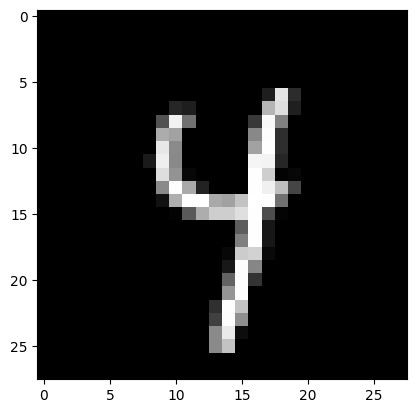

In [3]:
plt.imshow(xbar.reshape((28, 28)), cmap="gray")
print(f"Label weights for training example:\n {nn.predict_proba(xbar)}")
print(f"\nPredicted label is {nn.predict(xbar)}")

## Optimization model

- Index $l=4$ of $y$ is correct.  Can we trick the NN to classify a nearby image with index $w=9$?
- If we find an image $x$ with $y_w - y_l \ge 0$: counter example found
- If we prove that $y_w - y_l < 0$: no counter-example exists (in the neighbourhood)

If we denote by $g$ the prediction function of the neural network, and $\delta$ the width of the neighbourhood around $\bar x$. Our full optimization model reads:

\begin{alignat}{3}
\max_{0 \le x \le 1, y} \quad & y_w - y_l\\
\mbox{s.t.} \quad & \|x - \bar{x}\|_1 \le \delta\\
& g(x) = y
\end{alignat}

## gurobipy model

In [4]:
m = gp.Model()
delta = 5
right_label = 4
wrong_label = 9

# Create input/output variables
x = m.addMVar(xbar.shape, lb=0.0, ub=1.0, name="x")
y = m.addMVar(nn.n_outputs_, lb=-np.inf, name="y")

# Constrain x to 1-norm neighbourhood around \bar x
eta = m.addMVar(xbar.shape, lb=0, ub=1, name="abs_diff")
m.addConstr(eta >= x - xbar)
m.addConstr(eta >= -x + xbar)
m.addConstr(eta.sum() <= delta);

# Objective: Maximize difference between wrong and correct label 
m.setObjective(y[wrong_label] - y[right_label], gp.GRB.MAXIMIZE)

Insert the neural network in the gurobipy model to link `x` and `y`.

In [5]:
# No activation function on output layer needed; reset it
nn.out_activation_ = "identity"

In [6]:
%%capture
# Reformulate neural network as constraints in gurobipy model
pred_constr = add_mlp_regressor_constr(m, nn, x, y)

In [7]:
# Restore activation
nn.out_activation_ = "softmax"

## Solving the model

In [8]:
m.Params.BestBdStop = 0.0
m.Params.BestObjStop = 0.0
m.optimize()

Set parameter BestBdStop to value 0
Set parameter BestObjStop to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1679 rows, 1778 columns and 41700 nonzeros
Model fingerprint: 0x6dedd378
Model has 100 general constraints
Variable types: 1778 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-13, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+00]
Presolve removed 1245 rows and 730 columns
Presolve time: 0.08s
Presolved: 434 rows, 1048 columns, 37809 nonzeros
Variable types: 967 continuous, 81 integer (76 binary)

Root relaxation: objective 2.559291e+03, 296 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0    

[[7.15940265e-13 1.37959057e-14 9.99321606e-11 2.58100456e-12
  1.26696068e-02 9.09242419e-15 9.59255030e-21 5.39833400e-04
  1.48724798e-12 9.86790560e-01]]

Solution is classified as ['9']
Number of changed pixels: 10


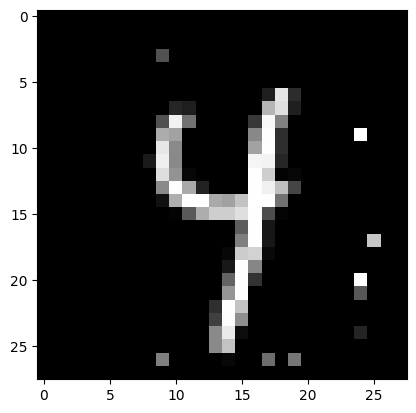

In [9]:
plt.imshow(x.X.reshape((28, 28)), cmap="gray")

print(nn.predict_proba(x.X))
print(f"\nSolution is classified as {nn.predict(x.X)}")
print(f"Number of changed pixels: {np.count_nonzero(xbar - x.X)}")

# Thanks!

#### luce@gurobi.com